In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
# install python packages
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1716567260010_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ec/57/56b9bcc3c9c6a792fcbaf139543cee77261f3651ca9da0c93f5c1221264b/python_dateutil-2.9.0.post0-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9d/ea/6d76df31432a0e6fdf81681a895f009a4bb47b3c39036db3e1b528191d52/pyparsing-3.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cach

In [3]:
# import python packages
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lower, regexp_replace, regexp_extract, trim, udf
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, RegexTokenizer
from pyspark.ml.clustering import LDA
from pyspark.sql.types import IntegerType, ArrayType, StringType
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Read the JSON file from S3
path = 's3://macs30213-thomas/arxiv.json'
data = spark.read.json(path)
data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- authors_parsed: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- categories: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- id: string (nullable = true)
 |-- journal-ref: string (nullable = true)
 |-- license: string (nullable = true)
 |-- report-no: string (nullable = true)
 |-- submitter: string (nullable = true)
 |-- title: string (nullable = true)
 |-- update_date: string (nullable = true)
 |-- versions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- created: string (nullable = true)
 |    |    |-- version: string (nullable = true)

In [5]:
# Extract abstracts and publication dates
df = data.select('abstract', 'update_date')

# Extract publication years
df = df.withColumn("year", col("update_date").substr(1, 4))

# Preprocess text
df = df.withColumn('abstract', lower(col('abstract'))) # convert to lowercase
df = df.withColumn('abstract', regexp_replace(col('abstract'), '[^a-zA-Z\s]', '')) # remove punctuation 
df = df.withColumn('abstract', trim(col('abstract'))) # remove trailing spaces

# Tokenize text
tokenizer = RegexTokenizer(inputCol="abstract", outputCol="words", pattern="\\W")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="tokens")

# Convert text to vectors
vectorizer = CountVectorizer(inputCol="tokens", outputCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer])

# Fit and transform data
model = pipeline.fit(df)
dataset = model.transform(df)

# Display processed data
dataset = dataset.select('tokens', 'features', 'year')
dataset.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----+
|              tokens|            features|year|
+--------------------+--------------------+----+
|[fully, different...|(262144,[1,11,20,...|2008|
|[describe, new, a...|(262144,[2,5,14,1...|2008|
|[evolution, earth...|(262144,[0,1,5,12...|2008|
|[show, determinan...|(262144,[3,222,24...|2007|
|[paper, show, com...|(262144,[3,4,8,69...|2013|
|[study, twopartic...|(262144,[2,5,6,9,...|2015|
|[rather, nonstand...|(262144,[0,3,6,8,...|2008|
|[general, formula...|(262144,[2,7,18,3...|2009|
|[discuss, results...|(262144,[1,2,5,6,...|2010|
|[partial, cubes, ...|(262144,[2,8,14,2...|2007|
|[paper, present, ...|(262144,[4,8,13,1...|2008|
|[recently, bruini...|(262144,[4,5,8,9,...|2007|
|[serre, obtained,...|(262144,[4,5,8,15...|2008|
|[article, discuss...|(262144,[15,23,12...|2009|
|[pure, spinor, fo...|(262144,[6,8,18,3...|2009|
|[work, evaluate, ...|(262144,[0,2,5,16...|2008|
|[results, spectro...|(262144,[0,2,12,1...|2009|
|[give, prescripti..

In [6]:
# Set up LDA
lda = LDA(k=4, maxIter=10, featuresCol='features')

# Fit LDA
lda_model = lda.fit(dataset)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Extract vocabulary from CountVectorizer
vocab = model.stages[2].vocabulary

# Convert term indices to words
def map_indices_to_words(term_indices):
    return [vocab[index] for index in term_indices]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Extract top 10 weighted terms in each topic
topics = lda_model.describeTopics(maxTermsPerTopic=10)

# Display top 10 weighted terms in each topic
topics_with_words = topics.rdd.map(lambda row: (row['topic'], map_indices_to_words(row['termIndices']))).toDF(['topic', 'terms'])
topics_with_words.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------------------------------------------------------------------------------------+
|topic|terms                                                                                |
+-----+-------------------------------------------------------------------------------------+
|0    |[quantum, model, field, energy, using, results, two, show, also, magnetic]           |
|1    |[data, model, models, learning, using, paper, method, performance, results, proposed]|
|2    |[n, show, model, number, graph, problem, also, results, two, algorithm]              |
|3    |[theory, also, show, space, paper, group, results, prove, study, functions]          |
+-----+-------------------------------------------------------------------------------------+

In [9]:
# Extract the most dominant topic for each document
def dominant_topic(topicDistribution):
    return max(range(len(topicDistribution)), key=lambda x: topicDistribution[x])
dominant_topic_udf = udf(dominant_topic, IntegerType())

# Convert topic index to labels
def map_topic_to_label(topic_index):
    return topic_labels.get(topic_index, "Unknown")
map_topic_to_label_udf = udf(map_topic_to_label, StringType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
topic_labels = {
    0: 'Physics',
    1: 'Computer Science',
    2: 'Math',
    3: 'Astronomy'
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Transform vectorized DataFrame to include topic distribution
topic_distribution = lda_model.transform(dataset)

# Extract the most dominant topics for each document
topic_distribution = topic_distribution.withColumn("dominant_topic", dominant_topic_udf("topicDistribution"))

# Map labels to topic index
topic_distribution = topic_distribution.withColumn("topic_label", map_topic_to_label_udf("dominant_topic"))

# Filter out null values and outliers
topic_distribution = topic_distribution.filter((dataset['year'].isNotNull()) & 
                                    (dataset['year'] >= 2000) & 
                                    (dataset['year'] <= 2025))


# Group by year and topic
topic_distribution = topic_distribution.groupBy("year", "topic_label").count()
topic_distribution = topic_distribution.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

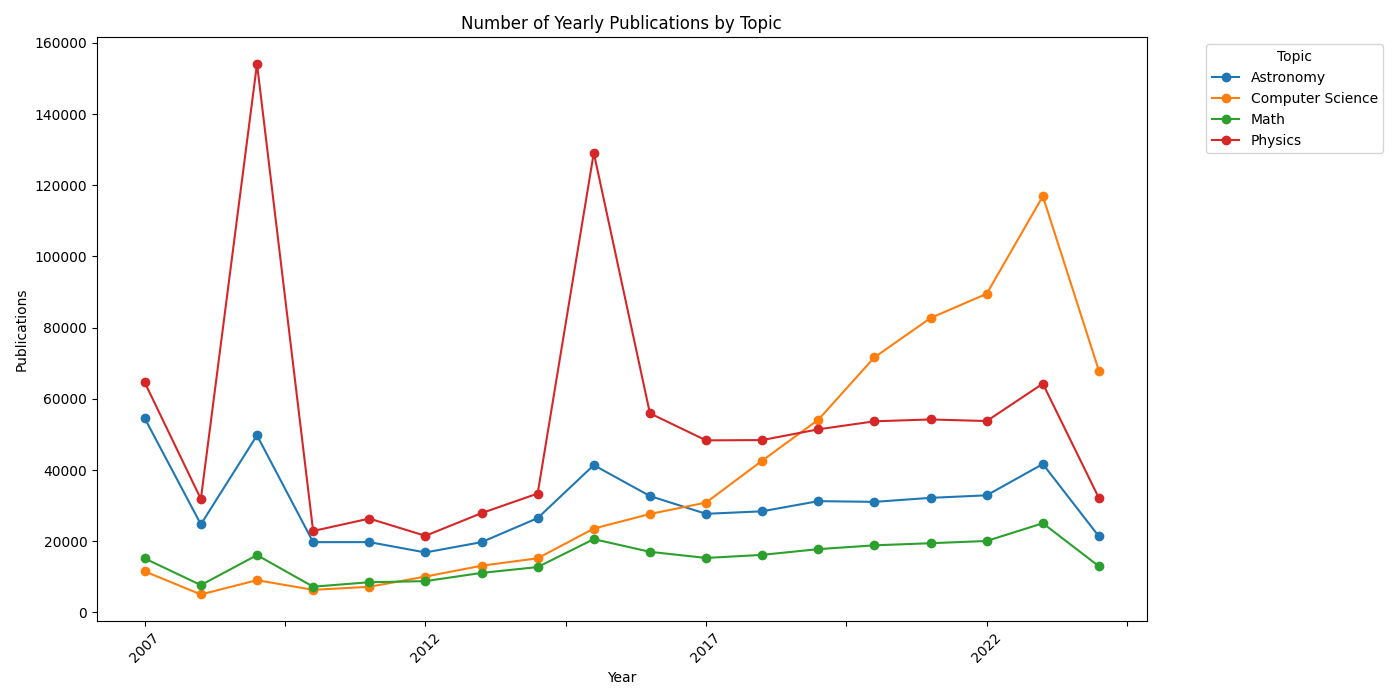

In [12]:
pivot_df = topic_distribution.pivot(index='year', columns='topic_label', values='count').fillna(0)

pivot_df.plot(kind='line', marker='o', figsize=(14, 7))
plt.title('Number of Yearly Publications by Topic')
plt.xlabel('Year')
plt.ylabel('Publications')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
%matplot plt